In [1]:
import numpy as np
import netCDF4 as NC
import matplotlib.pyplot as plt
import glob
import sisl

In [325]:
class HubbardH(object):
    
    def __init__(self, fn, t=[0,2.7,0.2,0.18], R=[0.1,1.6,2.6,3.1], U=5., nsc=[1,1,1]):
        # Save parameters
        self.fn = fn
        self.t = t # [onsite,1NN,2NN,3NN]
        self.R = R # [0.1,r1,r2,r3]
        self.U = U # Onsite Coulomb repulsion
        self.geom = sisl.get_sile(fn).read_geom()
        self.geom.sc.set_nsc(nsc)
        # Determine pz sites
        Hlist = []
        for ia in self.geom:
            if self.geom.atoms[ia].Z == 1:
                Hlist.append(ia)
        self.pi_geom = self.geom.remove(Hlist)
        print 'Found %i pz sites'%len(self.pi_geom)
        # Set hoppings
        self.set_hoppings()
        self.conv = {}
        
    def set_hoppings(self):
        # Build hamiltonian for backbone
        self.H0 = sisl.Hamiltonian(self.pi_geom)
        for ia in self.pi_geom:
            idx = self.pi_geom.close(ia,R=self.R)
            for j,ti in enumerate(self.t):
                if ti != 0:
                    self.H0.H[ia,idx[j]] = -ti

    def init_spins(self,dN):
        self.Hup = self.H0.copy()
        self.Hdn = self.H0.copy()
        # Determine how many up's and down's
        sites = len(self.pi_geom)
        self.Nup = int(sites/2+dN)
        self.Ndn = int(sites-self.Nup)
        print 'Nup, Ndn, dN =',self.Nup, self.Ndn, self.Nup-self.Ndn, 
        assert self.Nup+self.Ndn == sites
        self.nup = np.random.rand(sites)
        self.nup = self.nup/np.sum(self.nup)*self.Nup
        self.ndn = np.random.rand(sites)
        self.ndp = self.ndn/np.sum(self.ndn)*self.Ndn
            
    def get_polarization(self):
        pol = self.nup-self.ndn
        print 'Pol=',np.sum(pol)
        print 'nup=',np.sum(self.nup)
        return pol
        
    def iterate(self,mix=1.0):
        nup = self.nup
        ndn = self.ndn
        Nup = self.Nup
        Ndn = self.Ndn
        # Solve eigenvalue problems
        ev_up, evec_up = self.Hup.eigh(eigvals_only=False)
        ev_dn, evec_dn = self.Hdn.eigh(eigvals_only=False)
        # Compute new occupations
        niup = np.sum(np.power(evec_up[:,:int(Nup)],2),axis=1).real
        nidn = np.sum(np.power(evec_dn[:,:int(Ndn)],2),axis=1).real
        # Measure of density change
        dn = np.sum(abs(nup-niup))
        # Update occupations
        self.nup = mix*niup+(1.-mix)*nup
        self.ndn = mix*nidn+(1.-mix)*ndn
        # Compute total energy
        self.Etot = np.sum(ev_up[:int(Nup)])+np.sum(ev_dn[:int(Ndn)])-self.U*np.sum(nup*ndn)
        # Update Hamiltonian
        for ia in self.pi_geom:
            self.Hup.H[ia,ia] = self.U*self.ndn[ia]
            self.Hdn.H[ia,ia] = self.U*self.nup[ia]
        #self.get_polarization()
        return dn,self.Etot
        
    def plot_polarization(self,f=100):
        import matplotlib.pyplot as plt
        x = self.pi_geom.xyz[:,0]
        y = self.pi_geom.xyz[:,1]
        pol = self.nup-self.ndn
        fig = plt.figure(figsize=(6,6))
        axes = plt.axes()
        axes.set_aspect('equal') 
        scatter1 = axes.scatter(x,y,f*pol,'r'); # pos. part, marker AREA is proportional to data
        scatter2 = axes.scatter(x,y,-f*pol,'g'); # neg. part
        plt.show()
        
    def save_state(self):
        self.conv[self.U] = [1*self.nup,1*self.ndn,self.Hup.copy(),self.Hdn.copy(),self.Etot]
        
    def retrieve_state(self,U):
        [self.nup,self.dn,self.Hup,self.Hdn,Etot] = self.conv[U]
        self.U = U

In [329]:
HS = HubbardH('/home/thf/Dropbox/Sofia/Kondo-project/GGA/mol6/SP_0/molecule.XV',U=3.)
HS.init_spins(0)
HT = HubbardH('/home/thf/Dropbox/Sofia/Kondo-project/GGA/mol6/SP_0/molecule.XV',U=3.)
HT.init_spins(1)

# precondition with weak mixing
[HS.iterate(mix=.1) for i in range(30)];
[HT.iterate(mix=.1) for i in range(30)];

Found 112 pz sites
Nup, Ndn, dN = 56 56 0 Found 112 pz sites
Nup, Ndn, dN = 57 55 2


0 1.4750950461106527e-10 -324.52538014343565 2.7025341686748305e-08 -324.50783184712225
10 0.024404070895071905 -313.4522448342276 0.02912106777057838 -313.42702276080894
20 0.0024736141498622466 -313.45238469814126 0.004343256876466028 -313.42728834979465
30 0.0002482115088177639 -313.45238615105916 0.000671780733163263 -313.4272950829549
40 2.4916949202535843e-05 -313.4523861657642 0.00010829808590878676 -313.4272952694679
50 2.503337976356157e-06 -313.4523861659129 1.809588110557314e-05 -313.4272952749475
60 2.516517123574147e-07 -313.45238616591445 3.1271236593521934e-06 -313.427295275113
70 2.5309052242850072e-08 -313.45238616591456 5.573215243193097e-07 -313.4272952751181
80 2.546317989793323e-09 -313.4523861659145 9.887055718582616e-08 -313.4272952751182
90 2.5627400201955197e-10 -313.4523861659145 1.7465214441347854e-08 -313.4272952751182


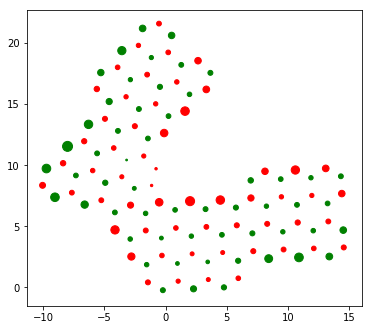

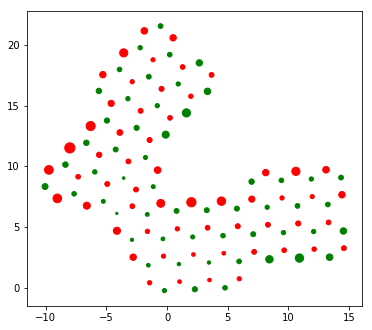

In [352]:
HS.U = 4.4
HT.U = HS.U
for i in range(100):
    dnS, ES = HS.iterate(mix=1)
    dnT, ET = HT.iterate(mix=1)
    if i%10==0:
        print i, dnS, ES, dnT, ET
HS.plot_polarization(f=300)
HT.plot_polarization(f=300)

In [353]:
HS.save_state()
HT.save_state()

[[3.         3.2        3.4        3.6        3.8        4.
  4.2        4.4       ]
 [0.03585933 0.02717058 0.0212453  0.01765568 0.01655156 0.01801835
  0.021204   0.02509089]]


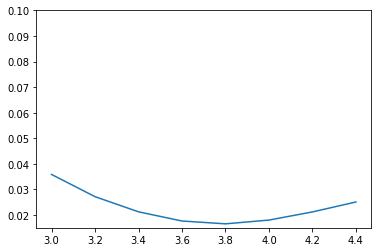

In [356]:
dat = []
for i in HS.conv.keys():
    dat.append([i,HT.conv[i][4]-HS.conv[i][4]])
dat.sort()
dat = np.array(dat).T
print dat
plt.plot(dat[0],dat[1])
plt.ylim([0.015,0.1])
plt.show()

In [303]:
HH.retrieve_state(3.2)

0 2.0050627824730327e-13 -346.8990041769387
1 2.823297151621773e-13 -346.8376142325477
2 2.2620794126737565e-13 -346.83761423254765
3 1.5931700403370996e-13 -346.8376142325477
4 2.061129045216603e-13 -346.8376142325476
5 2.7006175074006933e-13 -346.8376142325477
6 2.0067281170099704e-13 -346.8376142325477
7 2.896016759734721e-13 -346.8376142325477
8 3.3306690738754696e-13 -346.83761423254765
9 2.7200464103316335e-13 -346.8376142325477
10 3.5388358909926865e-13 -346.8376142325477
11 3.3467673077325344e-13 -346.8376142325476
12 2.1393997684526767e-13 -346.8376142325477
13 2.9282132274488504e-13 -346.8376142325477
14 1.8424151093654473e-13 -346.83761423254765
15 2.476907567938724e-13 -346.8376142325477
16 2.548516953027047e-13 -346.8376142325476
17 2.993161274389422e-13 -346.8376142325477
18 2.473021787352536e-13 -346.83761423254765
19 2.5568436257117355e-13 -346.8376142325476
20 2.3669954885008337e-13 -346.8376142325477
21 2.4225066397320916e-13 -346.8376142325476
22 3.566036355096003e-1

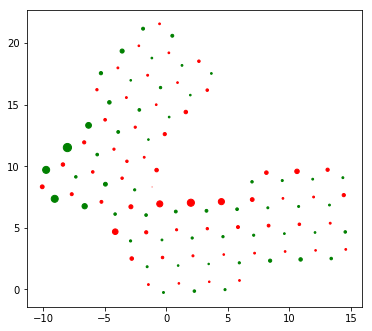

In [266]:
for i in range(100):
    dn, E = HH.iterate(mix=1)
    if i%1==0:
        print i, dn, E
HH.save_state()
HH.plot_polarization(f=300)

In [259]:
H0 = getH0('molecule.XV',t1=2.7,t2=0.2,t3=0.18)

Nup = 14
Ndn = 14
U = 3.0

Hup = H0.copy()
Hdn = H0.copy()

NameError: name 'getH0' is not defined

In [60]:
ev_up, evec_up = Hup.eigh(eigvals_only=False)
ev_dn, evec_dn = Hdn.eigh(eigvals_only=False)

# Obtain site-resolved density
nup = np.sum(np.power(evec_up[:,:int(Nup)],2),axis=1).real
ndn = np.sum(np.power(evec_dn[:,:int(Ndn)],2),axis=1).real

for ia in H0.geom:
    Hup.H[ia,ia] = U*ndn[ia]
    Hdn.H[ia,ia] = U*nup[ia]
    
print nup

[0.50269985 0.50622415 0.4926288  0.50618106 0.49278515 0.50618106
 0.51007167 0.4926288  0.49693939 0.49501151 0.49278515 0.49693939
 0.50269985 0.50622415 0.50622415 0.50269985 0.49693939 0.49278515
 0.49501151 0.49693939 0.4926288  0.51007167 0.50618106 0.49278515
 0.50618106 0.4926288  0.50622415 0.50269985]


In [2]:
def readNC(fn,ispin=0,nbands=20):
    nc = NC.Dataset(fn)
    kx = nc.variables['grid'][:,0]
    ev = nc.variables['eigenvalues'][:,ispin,-nbands:]
    nc.close()
    return kx,ev


In [3]:
def analyse(geom,t1,t2,t3):
    #global backbone
    molecule = sisl.get_sile(geom)
    mol = molecule.read_geom()
    mol.sc.set_nsc([3,1,1])
    #mol = mol.translate( -mol.center(what='xyz') )
    # mol.atom[0] = sisl.Atom(1,R=1.2) # how to set a radius!!!
    Hlist = []
    for ia in mol:
        if mol.atoms[ia].Z==1:
            Hlist.append(ia)
    backbone = mol.remove(Hlist)
    H = sisl.Hamiltonian(backbone)
    # Define radii for 1NN, 2NN, 3NN etc
    Rsph = [0.1,1.6,2.6,3.1,3.5]
    bondlengths = []
    for ia in backbone:
        idx,rij = backbone.close(ia,R=Rsph,ret_rij=True)
        bondlengths += [r for r in rij[1:]]
        H[ia,idx[0]] = 0.0
        H[ia,idx[1]] = -t1 # C-C bond 2.7
        if third:
            H[ia,idx[2]] = -t2 # C-C bond 0.2
            H[ia,idx[3]] = -t3 # C-C bond 0.18
    return H

def TBbands(geom,t1,t2,t3):
    H = analyse(geom,t1,t2,t3)
    klist = np.linspace(0,0.5,101)
    eigs = np.empty([len(klist), H.no])
    for ik, k in enumerate(klist):
        eigs[ik,:] = H.eigh([k,0,0], eigvals_only=True)
    return klist,eigs

In [116]:
def mkplots(t1=2.7,t2=0.2,t3=0.18):
    if t2 > 0 or t3 > 0:
        tb = '3NN'
    else:
        tb = '1NN'

    # Read structure from here:
    ka,evtb = TBbands('LDA/31-ribbon/8.870/molecule.XV',t1,t2,t3)
    ka = 2*ka # Units ka/pi
    egap = (evtb[0,14]+evtb[0,13])/2 # determine midgap

    for xc in [r'LDA', r'GGA']:
        if 'LDA' in xc:
            fn = xc+'/31-ribbon/8.870/Ebands/Electrons.nc' # LDA minimum
        else:
            fn = xc+'/31-ribbon/8.970/Ebands/Electrons.nc' # GGA minimum
        fig = plt.figure(figsize=(4,6));
        axes = plt.axes();

        # Add siesta bands
        k1,ev = readNC(fn)
        egap2 = (ev[0,9]+ev[0,10])/2
        plt.plot(ka,ev-egap2,'k');
        # Add TB results
        plt.plot(ka, evtb-egap, 'r')
        plt.ylim(-4,4)
        plt.rc('font', family='Bitstream Vera Serif', size=16)
        plt.rc('text', usetex=True)

        axes.set_title(xc+r' vs.~'+tb)
        axes.set_xlabel(r'$ka/\pi$')
        axes.set_ylabel(r'$E_{nk}$ (eV)')
        #plt.xticks(np.arange(0,.6,0.1))
        plt.subplots_adjust(left=0.2)
        plt.savefig(xc+'-'+tb+'-%.2f-%.2f-%.2f.pdf'%(t1,t2,t3))
        plt.close('all')


In [118]:
for t in [2.7,2.8,2.9]:
    mkplots(t1=t, t2=0.0, t3=0.00)
    mkplots(t1=t, t2=0.2, t3=0.18)

In [117]:
mkplots(t1=2.9, t2=0.0, t3=0.0)

In [84]:
mkplots(t1=2.9, t2=0.2, t3=0.18)